# Decadal Prediction Module Demo

Aaron Spring and Riley Brady

---

To do:

* Add significantly more information in markdown headers

In [1]:
from esmtools.prediction import *
import matplotlib.pyplot as plt
%matplotlib inline

# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. 

## 1-dimensional output

In [2]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:   (area: 3, ensemble: 12, member: 10, period: 5, year: 20)
Coordinates:
  * year      (year) int64 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 ...
  * period    (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area      (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
  * ensemble  (ensemble) int64 3014 3023 3045 3061 3124 3139 3144 3175 3178 ...
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    tos       (period, year, area, ensemble, member) float32 ...
    sos       (period, year, area, ensemble, member) float32 ...
    AMO       (period, year, area, ensemble, member) float32 ...

In [4]:
control

<xarray.Dataset>
Dimensions:  (area: 3, period: 5, year: 300)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 ...
  * period   (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area     (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
Data variables:
    tos      (period, year, area) float32 ...
    sos      (period, year, area) float32 ...
    AMO      (period, year, area) float32 ...

## 3-dimensional output

In [5]:
ds3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds3d.nc')
control3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control3d.nc')

In [6]:
control3d

<xarray.Dataset>
Dimensions:  (x: 256, y: 220, year: 50)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * year     (year) int64 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 ...
Dimensions without coordinates: x, y
Data variables:
    tos      (year, y, x) float32 ...
    sos      (year, y, x) float32 ...

In [7]:
ds3d

<xarray.Dataset>
Dimensions:   (ensemble: 4, member: 4, x: 256, y: 220, year: 5)
Coordinates:
    lon       (y, x) float64 ...
    lat       (y, x) float64 ...
  * year      (year) int64 1900 1901 1902 1903 1904
  * ensemble  (ensemble) int64 3014 3061 3175 3237
Dimensions without coordinates: member, x, y
Data variables:
    tos       (year, ensemble, member, y, x) float32 ...
    sos       (year, ensemble, member, y, x) float32 ...

# Predictability metrics

- available metrics: rmse, pearson_r, mse, PPP, uACC, ... see compute??

- available comparisons: m2m, m2e, m2c, e2c

In [8]:
help(rmse)

Help on function rmse in module xskillscore.core.deterministic:

rmse(a, b, dim)
    Root Mean Squared Error.
    
    Parameters
    ----------
    a : Dataset, DataArray, GroupBy, Variable, numpy/dask arrays or scalars
        Mix of labeled and/or unlabeled arrays to which to apply the function.
    b : Dataset, DataArray, GroupBy, Variable, numpy/dask arrays or scalars
        Mix of labeled and/or unlabeled arrays to which to apply the function.
    dim : str
        The dimension to apply the correlation along.
    
    Returns
    -------
    Single value or tuple of Dataset, DataArray, Variable, dask.array.Array or
    numpy.ndarray, the first type on that list to appear on an input.
        Root Mean Squared Error.
    
    See Also
    --------
    sklearn.metrics.mean_squared_error
    xarray.apply_unfunc



In [9]:
help(m2e)

Help on function m2e in module esmtools.prediction:

m2e(ds3d, supervector_dim)
    Create two supervectors to compare members to ensemble mean.



## 1-dimensional

In [10]:
varname='tos'
area='North_Atlantic'
period='ym'
#metric=rmse
metric=pearson_r
comparison=m2e
sig=99
bootstrap=100

In [11]:
def get_limit_sig(metric=pearson_r,sig=sig):
    if metric.__name__ in ['pearson_r', 'PPP', 'PM_MSSS']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

In [12]:
limit, sigl = get_limit_sig(metric=metric, sig=sig)

In [13]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

In [14]:
skill = compute(ds_, control_, metric=metric, comparison=comparison)
threshold =  PM_sig(ds_, control_, metric=metric, comparison=comparison, sig=sigl, bootstrap=bootstrap)

In [15]:
persistence = compute_persistence(ds_, control_, metric=metric, comparison=comparison)

In [16]:
ph = vectorized_predictability_horizon(skill, threshold, limit=limit).values

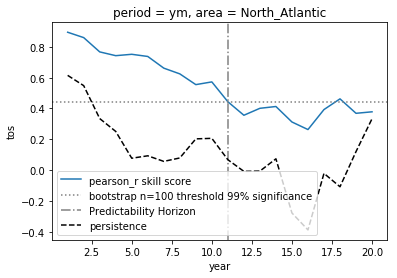

In [17]:
skill.plot(label=metric.__name__+' skill score')
plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
persistence.plot(ls='--',c='k',label='persistence')
plt.legend()

## many variables at once

In [18]:
skill_many = compute(ds, control, metric=metric, comparison=comparison)

### prediction skill varies with season

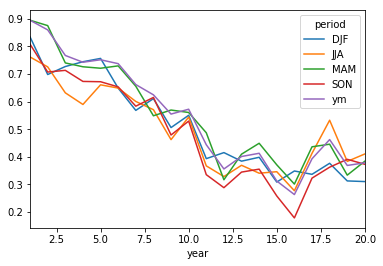

In [19]:
skill_many.sel(area=area).to_dataframe()[varname].unstack().T.plot()

### Predictability Horizon

In [20]:
threshold_many = PM_sig(ds, control, metric=metric, comparison=comparison, sig=sigl, bootstrap=bootstrap)

In [21]:
ph_many = vectorized_predictability_horizon(skill_many, threshold_many, limit=limit)

In [22]:
ph_many.to_dataframe().T.astype(int)

area   global                 North_Atlantic                  \
period    DJF JJA MAM SON  ym            DJF JJA MAM SON  ym   
tos         4   5   5   4   5             10  10  11  10  11   
sos        16  16  16  16  18             10  10   9  10  10   
AMO         2   2   2   2   2              2   2   2   2   2   

area   North_Atlantic_SPG                  
period                DJF JJA MAM SON  ym  
tos                    10   9  10   9  10  
sos                     9  10  10  10  10  
AMO                     2   2   2   2   2

# 3d

In [23]:
skill3d = compute(ds3d[varname], control3d[varname], metric=metric, comparison=comparison)

In [24]:
threshold3d = PM_sig(ds[varname], control3d[varname], metric=metric, comparison=comparison, sig=sigl, bootstrap=bootstrap)

/Users/ribr5703/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Skill for Lead Year

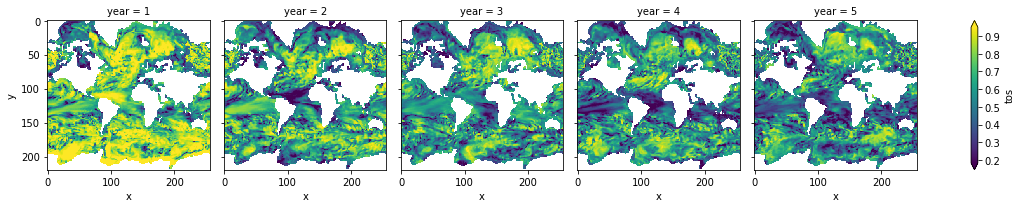

In [25]:
skill3d.plot(robust=True,yincrease=False, col='year')

## Predictability Horizon map

In [26]:
if limit == 'upper':
    masked = skill3d.where(skill3d > threshold3d)
elif limit == 'lower':
    masked = skill3d.where(skill3d < threshold3d)

In [27]:
ph3d = vectorized_predictability_horizon(masked, threshold3d, limit=limit)

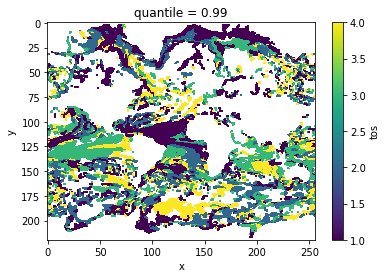

In [28]:
ph3d.where(ph3d>0).plot(yincrease=False)

# misc variability

## DPP

In [29]:
help(DPP)

Help on function DPP in module esmtools.prediction:

DPP(ds, m=10, chunk=True, var_all_e=False, time_dim='year')
    Calculate Diagnostic Potential Predictability (DPP) as potentially predictable variance fraction (ppvf) in Boer 2004.
    
    Note: Different way of calculating it than in Seferian 2018 or Resplandy 2015,
    but quite similar results.
    
    References
    ----------
    - Boer, G. J. “Long Time-Scale Potential Predictability in an Ensemble of
        Coupled Climate Models.” Climate Dynamics 23, no. 1 (August 1, 2004):
        29–44. https://doi.org/10/csjjbh.
    - Resplandy, L., R. Séférian, and L. Bopp. “Natural Variability of CO2 and
        O2 Fluxes: What Can We Learn from Centuries-Long Climate Models
        Simulations?” Journal of Geophysical Research: Oceans 120, no. 1
        (January 2015): 384–404. https://doi.org/10/f63c3h.
    - Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the
        Decadal Predictability of Land and Ocean C

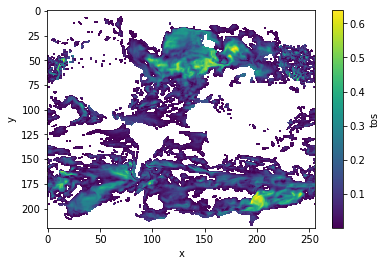

In [30]:
DPP = et.prediction.DPP(control3d[varname], m=10)
DPP.where(DPP>0).plot(yincrease=False)

## varweigthed mean period

In [31]:
help(et.stats.vec_varweighted_mean_period)

Help on function vec_varweighted_mean_period in module esmtools.stats:

vec_varweighted_mean_period(ds)
    Calculate the variance weighted mean period of an xr.DataArray.
    
    Reference
    ---------
    - Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value Decadal
      Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27, 2010):
      6292–6311. https://doi.org/10/bwq92h.



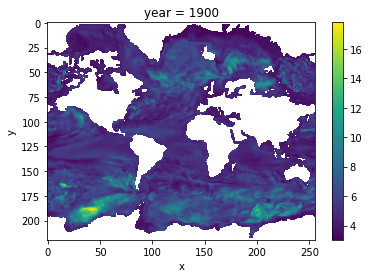

In [32]:
varweighted_mean_period = et.stats.vec_varweighted_mean_period(control3d[varname])
varweighted_mean_period.plot(yincrease=False)

## decorr time

In [33]:
help(et.stats.vec_tau_d)

Help on function vec_tau_d in module esmtools.stats:

vec_tau_d(da, r=20, dim='year')
    Calculate decorrelation time of an xr.DataArray.
    
    tau_d = 1 + 2 * sum_{k=1}^(infinity)(alpha_k)
    
    Reference
    ---------
    - Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate
    Research. Cambridge ; New York: Cambridge University Press, 1999., p.373



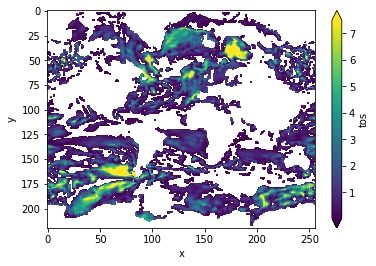

In [34]:
decorr_time = et.stats.vec_tau_d(control3d[varname])
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=True)